In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import fmin_tnc 
from numpy import log
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def prob(theta, x):
    return sigmoid(np.dot(x, theta))
def objective(theta, x, y):
# Computes the (negative of the) objective function, for all the training
    p = prob(theta, x)
    return -np.sum(y * log(p) + (1 - y) * log(1 - p))
def gradient(theta, x, y):
# Computes the gradient of the cost function at the point theta 
    return np.dot(x.T, sigmoid(np.dot(x, theta)) - y)
    # returns array of 3*1 representing the gradient
def fit(x, y, theta):
    return fmin_tnc(func=objective, x0=theta, fprime=gradient, args=(x, y))[0]

In [3]:
data = pd.read_csv("marks.txt",header=None)
# X = feature values, all the columns except the last column
X = data.iloc[:, :-1]
# Data normalization
# X = feature values, all the columns except the last column
X.iloc[:,0] = (X.iloc[:,0]-min(X.iloc[:,0]))/(max(X.iloc[:,0])-min(X.iloc[:,0]))
X.iloc[:,1] = (X.iloc[:,1]-min(X.iloc[:,1]))/(max(X.iloc[:,1])-min(X.iloc[:,1]))
X = np.c_[np.ones((X.shape[0], 1)), X]
## augment with column of ones
# reason for the three parameters now that x is n by 3
# y = target values, last column of the data frame
y = data.iloc[:, -1].to_numpy()
# select the applicants that got admitted vs. not admitted

## Preprocessing the X values
### X_processed for backtracking gradient descent
I've found that the large X values has made the convergence process very difficult, while weights with larger absolute value would help with the convergence rate. 

Therefore, the grades will be divided with 100 to accelerate the convergence, while the bias b is left at 1. And we'll divide the weights by 100 at the end respectively and calculate their true values

### X for fmin_tnc
X is left the same for fmin_tnc

In [4]:
data = pd.read_csv("marks.txt",header=None)
X = data[data.columns[0:2]]
X_processed = X/100
X_processed

,0,1
0,0.346237,0.780247
1,0.302867,0.438950
2,0.358474,0.729022
3,0.601826,0.863086
4,0.790327,0.753444
...,...,...
95,0.834892,0.483803
96,0.422617,0.871039
97,0.993150,0.687754
98,0.553400,0.649319


In [5]:
X = np.c_[np.ones((X.shape[0], 1)), X]
X_processed = np.c_[np.ones((X.shape[0], 1)), X_processed]
## augment with column of ones
y = data.iloc[:, -1].to_numpy()
# select the applicants that got admitted vs. not admitted

## a) Implementation of GD algorithms
1. Backtracking linesearch
After trial and error, I've found that the following linesearch parameter minimises the number of iterations
$$\alpha = 0.5$$ 
$$\beta = 0.6$$  
2. Gradient descent
The gradient descent would utilize the stepsize $t$ calculagted from the function line_search during each one of the descent. As shown below, the problem converged in 2577 timesteps

In [6]:
def line_search(theta, X, y):
    alpha = 0.5
    beta = 0.6
    t = 1
    count = 0
    grad = gradient(theta, X,y)
    # ensure the line search is above the function value
    
    while objective((theta - t*gradient(theta, X, y)), X, y)\
    - (objective(theta, X, y) - alpha*t*np.dot(gradient(theta,X,y),gradient(theta,X,y))) > 0:
        t *= beta
        count += 1
    return t


        
def gradient_descent(theta, X, y):
#     lambda_path = [theta]
    lambda_1 = [0]
    lambda_2 = [0]
    grad = gradient(theta, X, y)
    count = 0
    while sum(abs(grad)) > 1e-6:
        t = line_search(theta, X, y)
        if count%100== 0: 
            print(theta, t, sum(abs(grad)), count)
        theta = theta - t*gradient(theta, X, y)
#         lambda_path.append(theta)
        if count%100 == 0:
            lambda_1.append(theta[1])
            lambda_2.append(theta[2])
        grad = gradient(theta, X, y) 
        count += 1
    return theta, lambda_1, lambda_2, count

### Theta value evolvement during convergence

In [7]:
theta, lambda_x, lambda_y, count = gradient_descent(np.ones(3), X_processed, y)
print(f"The final w weights calculated for \n score1: {theta[1]}, \n score2: {theta[2]}, \n const: {theta[0]}")
print(f"The exact newton's optimizer converged in {count} steps")

[1. 1. 1.] 0.027993599999999997 61.92546759693916 0
[-15.48962429  12.83320997  12.24752412] 0.046655999999999996 1.4147925036746853 100
[-19.34510982  16.004998    15.461896  ] 0.07776 0.8110846633012638 200
[-22.22517188  18.2786089   17.76945561] 0.1296 0.11830476531914577 300
[-23.1138777   18.98728823  18.48845288] 0.1296 0.06824635409469088 400
[-24.05421297  19.74174008  19.25355934] 0.07776 0.09197025388426167 500
[-24.57417006  20.15566112  19.67325765] 0.07776 0.04761890453493936 600
[-24.83249643  20.36095692  19.88138674] 0.07776 0.019799763320095032 700
[-24.97196074  20.47046372  19.99242215] 0.07776 0.018080462051719037 800
[-25.04642415  20.53099373  20.05374865] 0.36 0.004088506125647345 900
[-25.09258037  20.56802119  20.09127241] 0.6 0.002436065549460076 1000
[-25.11893425  20.58923117  20.11276477] 0.36 0.0013688758198452389 1100
[-25.13596634  20.60282184  20.12653872] 0.36 0.0008989474480940451 1200
[-25.14613599  20.6109833   20.13480916] 0.6 0.000531902642210119

In [8]:
theta_star = fit(X, y, np.zeros(3))
print(theta_star) 

[-25.10813434   0.20580621   0.20104113]


  NIT   NF   F                       GTG
    0    1  6.931471805599453E+01   2.71082898E+06
tnc: fscale = 0.000607364
    1    3  6.318123602637407E+01   7.89087141E+03
    2    5  6.304405281341421E+01   2.32276141E+04
    3    7  6.202363128171116E+01   6.99589856E+03
    4    9  6.200055732218346E+01   1.55410020E+04
    5   11  3.558838136436250E+01   7.60792863E+04
    6   13  3.461820001818324E+01   8.60837240E+04
tnc: stepmx = 1000
    7   16  2.334632697144787E+01   2.64420125E+04
    8   18  2.115934758630489E+01   4.47727707E+04
    9   20  2.069256189027394E+01   9.14400150E+01
tnc: fscale = 0.104576
   10   22  2.069159271126396E+01   1.81359192E+01
   11   24  2.066284965970637E+01   1.35653309E+02
   12   26  2.041404381345837E+01   6.13262090E+02
   13   28  2.039785847832362E+01   5.50436914E+02
   14   30  2.037970566616147E+01   1.97521365E+02
   15   32  2.035764486674633E+01   4.87743150E+02
   16   34  2.034985540960050E+01   1.14057388E+00
   17   36  2.0349825396

## b) Weights and bias comparison with fmin_tnc

It can be seen that the weights calculated with the backtracking line search is similar to the one calculated with fmin_tnc

The weights converged in 2577 steps to a precision of 1e-6. 

Weights with $\frac{1}{100}X$ from backtracking linesearch: 
$$w1 = 20.623$$
$$w2 = 20.147$$
$$b = -25.161$$

Final weights from linesearch:
$$w1 = 0.20623$$
$$w2 = 0.20147$$
$$b = -25.161$$

Weights from fmin_tnc:
$$w1 = 0.2058$$
$$w2 = 0.201$$
$$b = -25.1081$$

### True value of the the final weights from the backtracking gd

In [9]:
theta_final = theta
# adjusting back the weight values
theta_final[1]/=100
theta_final[2]/=100
theta_final

array([-25.16130328,   0.20623147,   0.20147135])

In [10]:
count

2577

# c) Plotting of weight changes
Preprocessing: calculation of the W1 and W2

In [11]:
W1 = np.linspace(0,21,210)
W2 = np.linspace(0,21,210)

In [12]:
def prob_2(w1, w2, b, x):
    return sigmoid(np.dot(x, np.array([b, w1, w2])))

def objective_2(w1, w2, b, x, y):
    p = prob_2(w1, w2, b, x)
    return -np.sum(y * log(p) + (1 - y) * log(1 - p))

In [13]:
objective_horizon = np.zeros([210, 210])
for i,w1 in enumerate(W1):
    for j, w2 in enumerate(W2):
        objective_horizon[i][j] = objective_2(w1, w2, -25.16130038, X_processed, y)

## c.1 Contour plots 
The bias b is set to the terminal value -25.1613, and the following plot showcases the evolvement of w1 and w2 in order to minimize the objective function

The blue dashed line shows the theta optimization tragectory, while the two red points mark their start and ending location

The blue dots are the sample points taken every 100 iteration for figure clearness

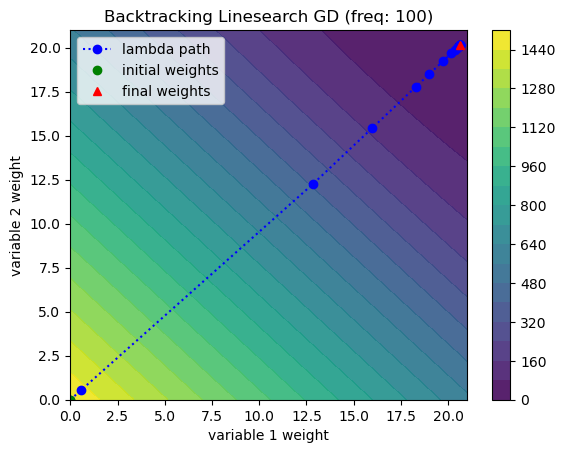

In [14]:
fig,ax = plt.subplots()
contourf_ = ax.contourf(W1, W2, objective_horizon, 20, alpha = 0.9)
cbar = fig.colorbar(contourf_)
ax.plot(lambda_x,lambda_y,'o:b')
ax.plot(lambda_x[0],lambda_y[0],'go')
ax.plot(lambda_x[-1],lambda_y[-1],'r^')
ax.set_xlabel('variable 1 weight')
ax.set_ylabel('variable 2 weight')
ax.title.set_text('Backtracking Linesearch GD (freq: 100)')
ax.legend(['lambda path', 'initial weights','final weights'])

## c.2 Result and accuracy comparison
We can observe that the results from backtracking linesearch + gradient descent is similar to the one derived from fmin_tnc

In [15]:
# prediction of results
results = np.where(sigmoid(np.matmul(X, theta_star)) > 0.5, 1, 0)
# accuracy score
print("accuracy score with fmin_tnc: ", accuracy_score(y,results))

results_gd = np.where(sigmoid(np.matmul(X, theta_final)) > 0.5, 1, 0)
print("accuracy score with backtracking GD: ", accuracy_score(y,results_gd))

accuracy score with fmin_tnc:  0.89
accuracy score with backtracking GD:  0.89


# d Newton's method 
## d.1 Exact Newton's method
Exact Newton's method with original X. For consistency, we'll divide the X values by 100 and divide the weights by 100 correspondingly for consistency between methods

The optimization converged in 9 steps

In [16]:
# define logistic regression
def logistic_regression(X,y):
    # initiate the w array
    w = np.array([0, 0, 0])
    # initiate the error array
    err = np.array([1, 1, 1])
    # start of conditional loop
    count = 0
    lambda_1 = [0]
    lambda_2 = [0]
    while (sum(abs(err)) > 1e-6):
        # sigmoid calculation (2.32)
        mu = sigmoid(np.matmul(X,w))
        # g calculation (2.36)
        g = np.matmul(X.T,mu-y)
        S = np.diag(mu*(1-mu))
        # Hessian matrix calculation
        H = np.matmul(np.matmul(X.T,S),X)
        # Error term calculation
        err = np.matmul(np.linalg.inv(H),g)
        w = w - err
        lambda_1.append(w[1])
        lambda_2.append(w[2])
        count += 1
    return w, count, lambda_1, lambda_2

w_final, count, lambda_1, lambda_2 = logistic_regression(X_processed,y)
print(f"The final w weights calculated for \n score1: {w_final[1]/100}, \n score2: {w_final[2]/100}, \n const: {w_final[0]}")
print(f"The exact newton's optimizer converged in {count} steps")

The final w weights calculated for 
 score1: 0.2062317132939833, 
 score2: 0.20147160044196377, 
 const: -25.161333566639566
The exact newton's optimizer converged in 9 steps


### Comments on Exact Newton's method
The optimiser converged quickly to the minimum within 9 steps, which is much quicker compared to the backtracking linesearch. Here the full lambda path is plotted

The reason being that the line search and gradient descent is first order algorithm, while the newton's method is second order

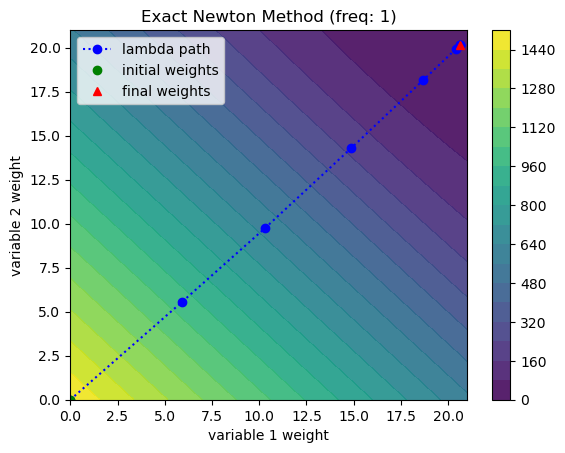

In [17]:
fig,ax = plt.subplots()
contourf_ = ax.contourf(W1, W2, objective_horizon, 20, alpha = 0.9)
cbar = fig.colorbar(contourf_)
ax.plot(lambda_1,lambda_2,'o:b')
ax.plot(lambda_1[0],lambda_2[0],'go')
ax.plot(lambda_1[-1],lambda_2[-1],'r^')
ax.legend(['lambda path', 'initial weights','final weights'])
ax.set_xlabel('variable 1 weight')
ax.set_ylabel('variable 2 weight')
ax.title.set_text('Exact Newton Method (freq: 1)')


## d.2 Newton's method with BT linesearch

In [18]:
def line_search_gradient(theta, X, y, d):
    alpha = 0.5
    beta = 0.6
    t = 1
    count = 0
    grad = gradient(theta, X,y)
    # ensure the line search is above the function value
    while objective((theta - t*d), X, y)\
        - (objective(theta, X, y) - alpha*t*np.dot(grad,d)) > 0:
        t *= beta
        count += 1
    return t


In [19]:
# define logistic regression
def logistic_regression(X,y):
    # initiate the w array
    w = np.array([0, 0, 0])
    # initiate the error array
    err = np.array([1, 1, 1])
    # start of conditional loop
    count = 0
    lambda_1 = [0]
    lambda_2 = [0]
    while (sum(abs(err)) > 1e-6):
        # sigmoid calculation (2.32)
        mu = sigmoid(np.matmul(X,w))
        # g calculation (2.36)
        g = np.matmul(X.T,mu-y)
        S = np.diag(mu*(1-mu))
        # Hessian matrix calculation
        H = np.matmul(np.matmul(X.T,S),X)
        # Error term calculation
        
#         print(t)
        err = np.matmul(np.linalg.inv(H),g)
        t = line_search_gradient(w, X, y, err)
        w = w - t*err


        lambda_1.append(w[1])
        lambda_2.append(w[2])
        count += 1
    return w, count, lambda_1, lambda_2

w_final, count, lambda_ls_1, lambda_ls_2 = logistic_regression(X_processed,y)
print(f"The final w weights calculated for \n score1: {w_final[1]/100}, \n score2: {w_final[2]/100}, \n const: {w_final[0]}")
print(f"The backtracking linesearch newton's optimizer converged in {count} steps")

The final w weights calculated for 
 score1: 0.2062317132939829, 
 score2: 0.20147160044196336, 
 const: -25.16133356663952
The backtracking linesearch newton's optimizer converged in 10 steps


### Comments on newton's method with linesearch
Even with the processed X value of $\frac{1}{100}$ and the backtracking linesearch, the function converged in 10 steps, which is similar to the exact newton's method. The blue dots are the descent tragectory

Therefore the addition of linesearch hurts the performance. 

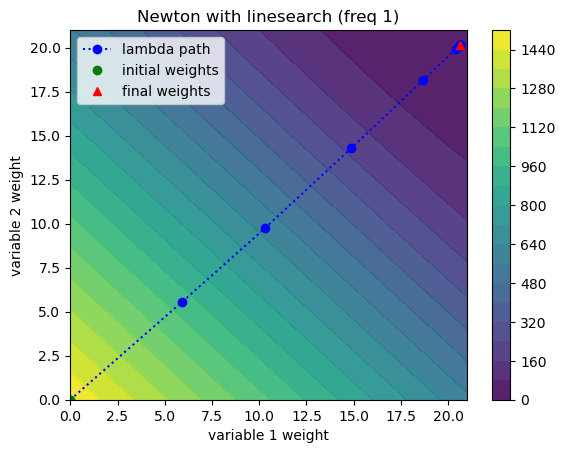

In [20]:
fig,ax = plt.subplots()
contourf_ = ax.contourf(W1, W2, objective_horizon, 20, alpha = 0.9)
cbar = fig.colorbar(contourf_)
ax.plot(lambda_ls_1,lambda_ls_2,'o:b')
ax.plot(lambda_ls_1[0],lambda_ls_2[0],'go')
ax.plot(lambda_ls_1[-1],lambda_ls_2[-1],'r^')
ax.set_xlabel('variable 1 weight')
ax.set_ylabel('variable 2 weight')
ax.legend(['lambda path', 'initial weights','final weights'])
ax.set_xlabel('variable 1 weight')
ax.set_ylabel('variable 2 weight')
ax.title.set_text('Newton with linesearch (freq 1)')